In [59]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
⌃ [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [60]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [61]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:J1, :K, :Lx, :Ly, :Mag, :Energy, :Dx0, :Dy0],
)

cleandata (generic function with 1 method)

In [62]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel)
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [63]:
jobname = "small-sys"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,J1,K,Lx,Ly,Mag,Energy,Dx0,Dy0
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,-2.0,-0.2,20,20,0.605±0.027,-4.056±0.053,0.94±0.025,0.91±0.026
2,-1.9,-0.2,20,20,0.597±0.023,-3.875±0.06,0.917±0.032,0.912±0.032
3,-1.8,-0.2,20,20,0.31±0.014,-3.66±0.067,0.885±0.039,0.878±0.038
4,-1.7,-0.2,20,20,0.342±0.019,-3.451±0.065,0.865±0.043,0.833±0.04
5,-1.6,-0.2,20,20,0.182±0.011,-3.249±0.067,0.781±0.048,0.769±0.047
6,-1.5,-0.2,20,20,0.2±0.013,-3.085±0.06,0.753±0.049,0.724±0.047
7,-1.4,-0.2,20,20,0.156±0.02,-2.956±0.062,0.737±0.057,0.733±0.057
8,-1.3,-0.2,20,20,0.1±0.012,-2.722±0.053,0.669±0.063,0.654±0.062
9,-1.2,-0.2,20,20,0.175±0.016,-2.611±0.045,0.59±0.06,0.551±0.055


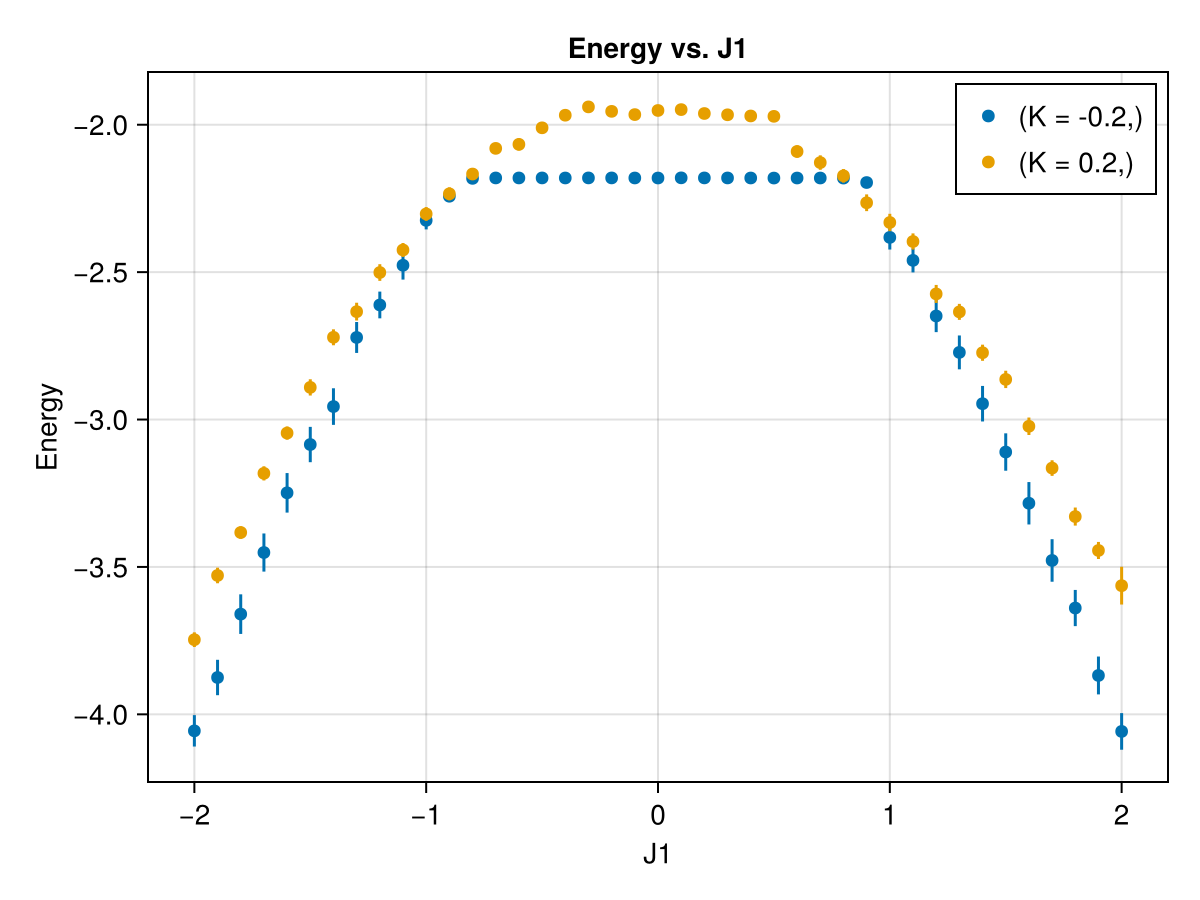

In [64]:
generatePlot(
    data, :J1, :Energy;
    title="Energy vs. J1",
    xlabel="J1",
    ylabel="Energy"
)

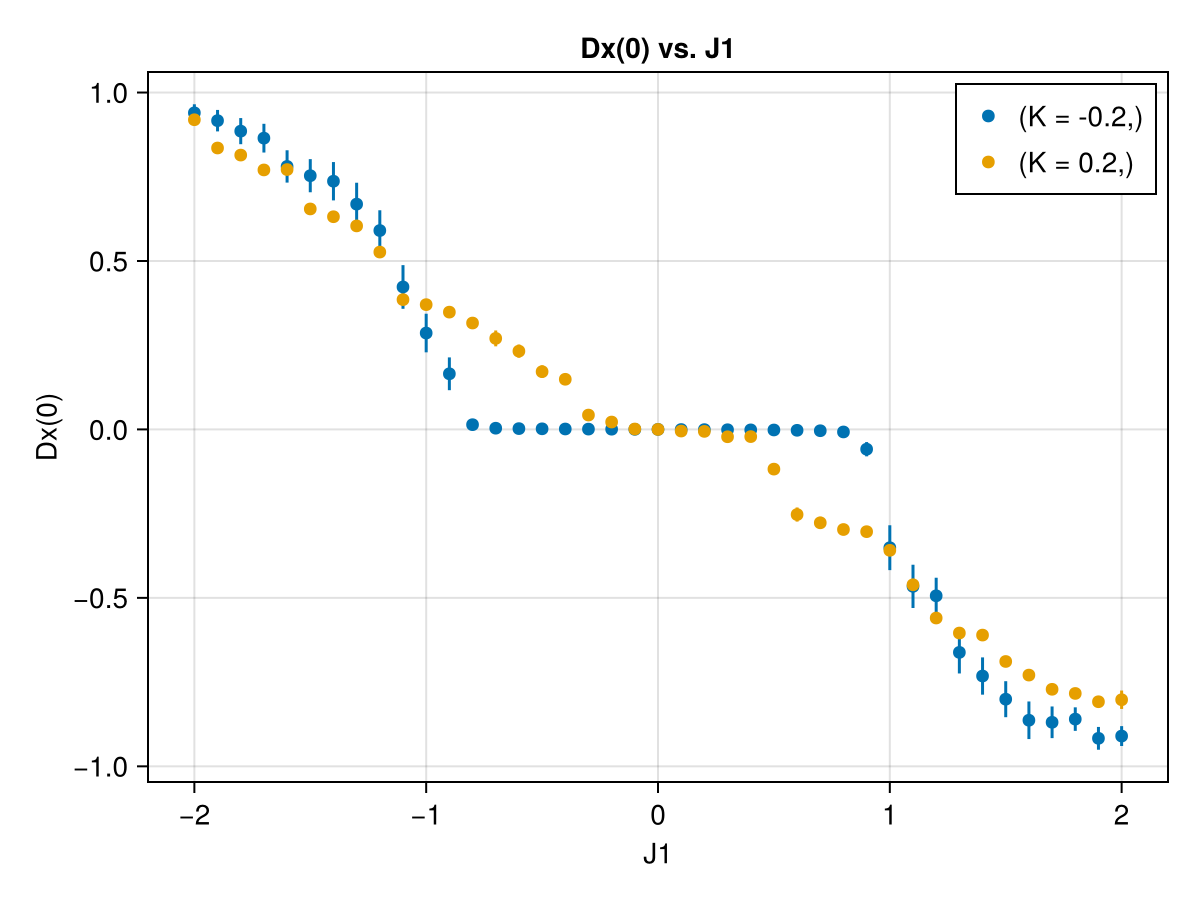

In [65]:
generatePlot(
    data, :J1, :Dx0;
    title="Dx(0) vs. J1",
    xlabel="J1",
    ylabel="Dx(0)"
)

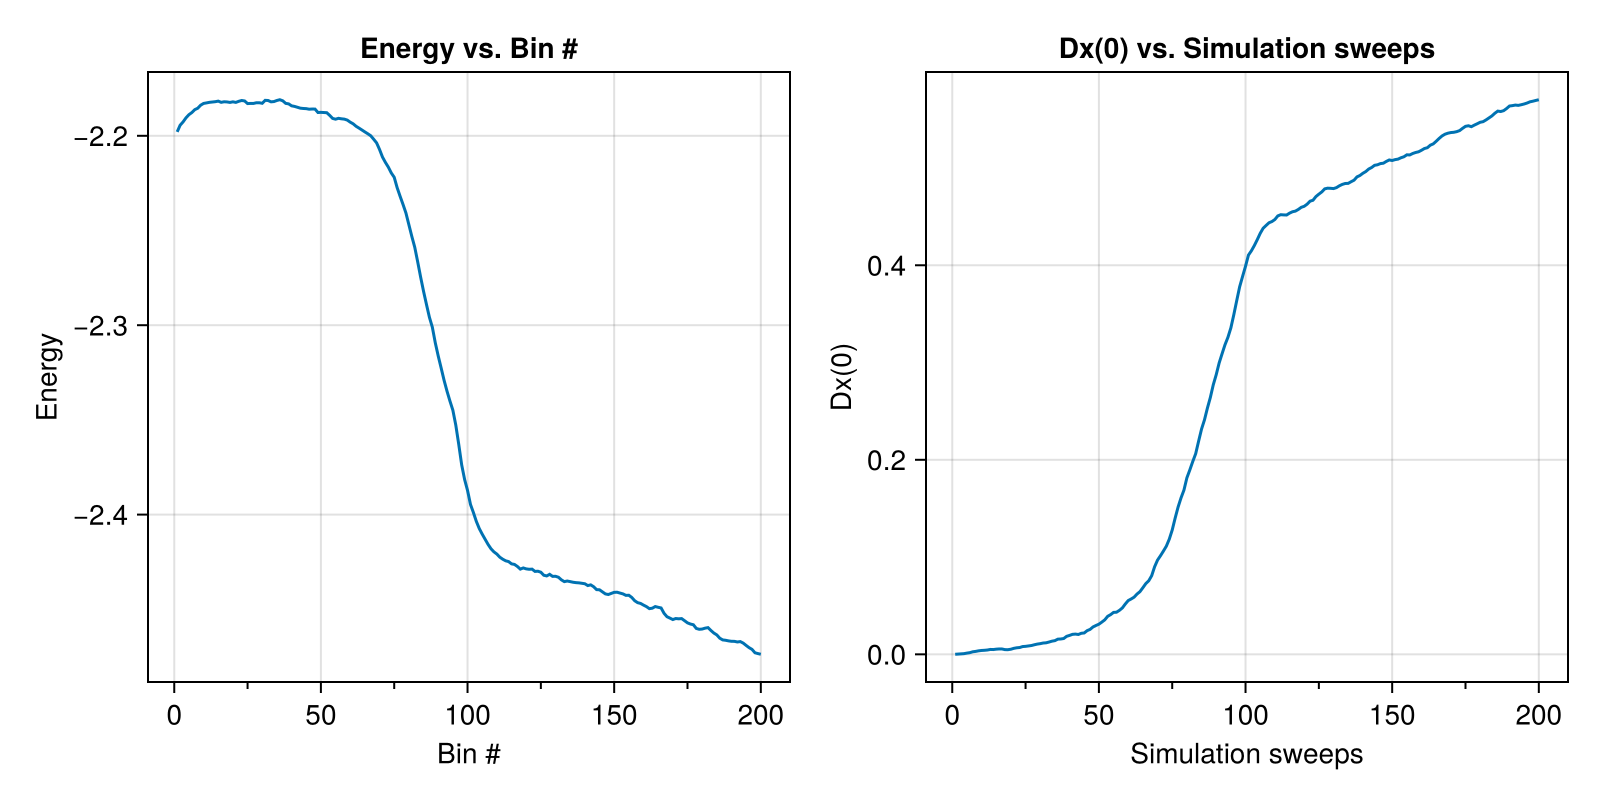

In [70]:
function generate_mctime_plot(task_no::Int)
    fig = Figure(size=(800, 400))

    ax_energy = fig[1,1] = Axis(
        fig,
        title="Energy vs. Bin #",
        xlabel="Bin #",
        ylabel="Energy",
        xminorticksvisible=true
    )
    ax_Dx0 = fig[1,2] = Axis(
        fig,
        title="Dx(0) vs. Simulation sweeps",
        xlabel="Simulation sweeps",
        ylabel="Dx(0)",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]
        energy_samples = read(observables, "Energy/samples")
        n = length(energy_samples)
        init = 1
        lines!(
            ax_energy,
            collect(init:n),
            energy_samples[init:n],
        )
        Dx0_samples = read(observables, "Dx0/samples")
        lines!(
            ax_Dx0,
            collect(init:n),
            Dx0_samples[init:n],
        )
    end

    return fig
end

generate_mctime_plot(11)

In [67]:
task_no = "21"
file = h5open("../jobs/" * jobname * ".data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

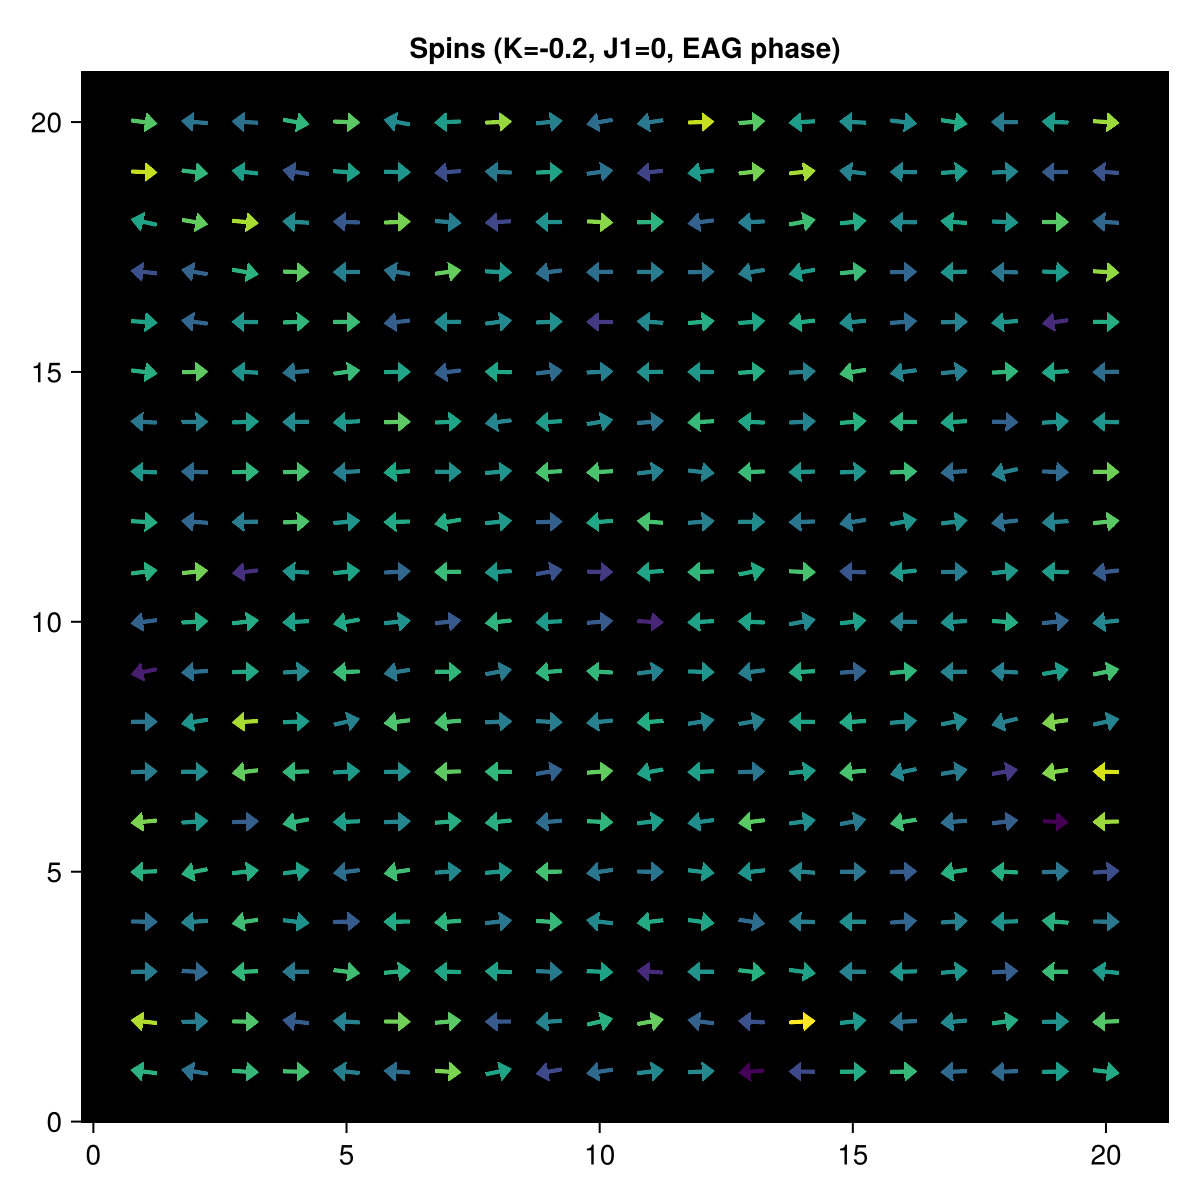

In [68]:
fig = Figure(size=(600, 600))
fig[1,1] = Axis(fig; title="Spins (K=-0.2, J1=0, EAG phase)", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig